# Lesson 7: Inverse Problems

Before we can use models and computer simulations for process design, we need to determine the values of the model parameters.

In this lesson, we will: 
- Learn the fundamentals of inverse problems.
- Learn how to setup, run and analyze a parameter basic estimations.

## Example 1: Manually determining porosity and axial dispersion of a Column

Later, we will be using optimization algorithms that can automatically determine these values for us. But for educational purposes, we will start by manually manipulating parameter values.


For determining the values the external porosity and the axial dispersion of a chromatographic column, an experiment was conducted in which a dextran pulse was injected into the column.
The system response (i.e. the concentration signal at the column outlet) was recoreded.

### Load CADETSettings

This imports all the standard libraries and provides some helper functions.

In [1]:
%run ../utils.ipynb

### Loading experimental data

First we will load experimental data from the `dextran.csv` file in the `resources` folder.
In the first column, it contains a vector of time points and in the second column the dextran concentration.
`csv` data can be loaded using the `loadtxt()` function of the numpy package.

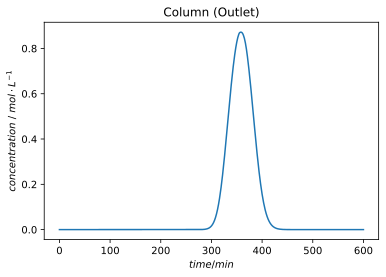

### Create reference model

First, we need to model our system.
For this purpose, we configure a `CADET` model as explained in the previous lessons.
In this exercise, we will reuse the previous example which included an `INLET`, a `LUMPED_RATE_MODEL_WITH_PORES`, and an `OUTLET`.
We can load a preconfigured model from the utils by calling `create_dextran_model`.

Since we don't know yet what the porosity and axial dispersion of the column are, we have to set arbitrary values for these parameters.
If we plot the result, we can see that the simulation and the experiment do not agree very well.

Simulation completed successfully


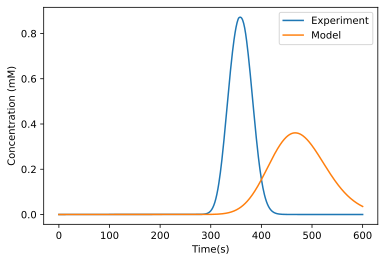

## Quantification of discrepancy

In order to quantify the the discrepancy between the data and an estimation model, we can use the sum of squared errors.
Later we will also look at some other measures (also called scores).


SSE 40.1


### Try to optimize manually

<div class="alert alert-info">

**Note:** 
    
The following cell mainly contains code to facilitate the interactive plot.
   
</div>


***Task:*** Try optimizing the function manually by moving the sliders and looking at the resulting plots, including the sum squared error as a score.

In [5]:
def goal(axial_dispersion=-5, column_porosity=0.4):
    axial_dispersion = 10**axial_dispersion
    
    # create and run simulation
    dextran_model_temp = Cadet(dextran_model.root)
    dextran_model_temp.root.input.model.unit_001.col_dispersion = axial_dispersion
    dextran_model_temp.root.input.model.unit_001.col_porosity = column_porosity
    run_simulation(dextran_model_temp)
    
    dextran_solution = dextran_model_temp.root.output.solution.unit_002.solution_outlet_comp_000

    
    # print error
    sse = np.sum((dextran_experiment - dextran_solution)**2 )   
    print('SSE %.3g' % sse)
    
    # create plots
    plt.figure()
    plt.plot(time_experiment, dextran_experiment, label='Experiment')
    plt.plot(dextran_model.root.output.solution.solution_times, dextran_solution, label='Model')
    plt.legend()
    plt.xlabel('Time(s)')
    plt.ylabel('Concentration (mM)')
    
interact(
    goal,
    axial_dispersion=widgets.FloatSlider(min=-10, max=-5, step=0.1, layout={'width': '500px'}, description='Axial Dispersion'),
    column_porosity=widgets.FloatSlider(min=0.1, max=0.9, step=0.01, layout={'width': '500px'}, description='Column Porosity'))

interactive(children=(FloatSlider(value=-5.0, description='Axial Dispersion', layout=Layout(width='500px'), ma…

<function __main__.goal>

## Example 2: Gradient descent based parameter estimation

A common approach for automatic parameter estimation is to use algorithms that try to minimize the SSE by following its gradient.
In this exercise we will see this in action and discuss the limiations of this approach.

While there exist many different gradient based optimization suites in Python, we will already be using `CADET-Match`.
For now we are just going to create this object and explain it later we will learn how to set up new problems with it.

***Task:*** The following cell contains code that lets you choose a starting point for gradient search by moving the sliders and then starting the search once you click the button. 
Go ahead and play around with it to see what happens when you look at different starting points.

In [6]:
def create_match_config(ax_dis, col_por):
    match_config = Dict()
    match_config.CADETPath = Cadet.cadet_path
    match_config.baseDir = Path('./').absolute().as_posix()
    match_config.resultsDir = 'results'
    match_config.searchMethod = 'Gradient'
    match_config.seeds = [(ax_dis, col_por),]
    match_config.gradVector = True
    
    parameter1 = Dict()
    parameter1.location = '/input/model/unit_001/COL_DISPERSION'
    parameter1.component = -1
    parameter1.bound = -1
    parameter1.min = 1e-10
    parameter1.max = 1e-5
    parameter1.transform = 'null'
    
    parameter2 = Dict()
    parameter2.location = '/input/model/unit_001/COL_POROSITY'
    parameter2.component = -1
    parameter2.bound = -1
    parameter2.min = 0.1
    parameter2.max = 0.9
    parameter2.transform = 'null'

    match_config.parameters = [parameter1, parameter2]

    experiment1 = Dict()
    experiment1.name = 'main'
    experiment1.csv = '../resources/dextran_experiment.csv'
    experiment1.HDF5 = 'dextran_reference.h5'
    experiment1.isotherm = '/output/solution/unit_002/SOLUTION_OUTLET_COMP_000'
 
    feature1 = Dict()
    feature1.name = 'Pulse'
    feature1.type = 'SSE'

    experiment1.features = [feature1,]

    match_config.experiments = [experiment1,]

    return match_config

def click_search(b):
    with output:
        clear_output(wait=True)
        print('Axial Dispersion', 10**axial_dispersion.value)
        print('Column Porosity', column_porosity.value)

    with output_search:
        clear_output(wait=True)

        match_config = create_match_config(10**axial_dispersion.value, column_porosity.value)
        match_config_file = Path('./dextran.json').absolute()
        with open(match_config_file, 'w') as json_file:
            json.dump(match_config.to_dict(), json_file, indent='\t')

        match = Match(match_config_file)
        match.start_sim()
    
    best, score, best_score = match.get_best()

    for data in best_score.values():
        axial_dispersion.value = np.log10(data[0])
        column_porosity.value = data[1]

        axial_dispersion_best = np.log10(data[0])
        column_porosity_best = data[1]

        goal(axial_dispersion_best, column_porosity_best)
        break


def goal(axial_dispersion=-5, column_porosity=0.4):
    axial_dispersion = 10**axial_dispersion

    with output:
        clear_output(wait=True)
        
        print('Axial Dispersion %.3g' % axial_dispersion)
        print('Column Porosity %.3g' % column_porosity)

        # create and run simulation
        dextran_model_temp = Cadet(dextran_model.root)
        dextran_model_temp.root.input.model.unit_001.col_dispersion = axial_dispersion
        dextran_model_temp.root.input.model.unit_001.col_porosity = column_porosity
        
        run_simulation(dextran_model_temp)

        # print error
        sse = np.sum((dextran_experiment - dextran_model_temp.root.output.solution.unit_002.solution_outlet_comp_000)**2 )
        print('SSE %.3g' % sse)

    with output_graph:
        clear_output(wait=True)
        
        # create plots
        plt.figure(figsize=[10,7])
        plt.plot(time_experiment, dextran_experiment, label='Experiment')
        plt.plot(dextran_model_temp.root.output.solution.solution_times,
                 dextran_model_temp.root.output.solution.unit_002.solution_outlet_comp_000, label='Test')
        plt.legend()
        plt.xlabel('Time(s)')
        plt.ylabel('Concentration (mM)')

        
style = {'description_width': 'initial'}
axial_dispersion = widgets.FloatSlider(min=-10, max=-5, step=0.1, layout={'width': '800px'}, style=style, description='Axial Dispersion')
column_porosity = widgets.FloatSlider(min=0.1, max=0.9, step=0.01, layout={'width': '800px'}, style=style, description='Column Porosity')
call_goal = interactive(goal, axial_dispersion=axial_dispersion, column_porosity=column_porosity)

button = widgets.Button(description='Start Gradient Search')
button.on_click(click_search)

output = widgets.Output()
output_graph = widgets.Output()
output_search = widgets.Output()

vbox = widgets.VBox([call_goal, button, output, output_graph, output_search])
display(vbox)